In [12]:
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import numpy as np
# read in baseline data
baseline_seed1_csv = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed1/training_results/training_res_seed1.csv')

if baseline_seed1_csv.exists():
    baseline_seed1_df = pd.read_csv(baseline_seed1_csv)
    print(f"Baseline Seed 1 data loaded: {len(baseline_seed1_df)} epochs")
else:
    print("Warning: Baseline Seed 1 data not found")

Baseline Seed 1 data loaded: 118 epochs


In [13]:
# Find the epoch with minimum test loss
baseline_min_test_loss_idx = baseline_seed1_df['test_loss'].idxmin()

# Keep all rows up to and including the minimum test loss epoch
baseline_filtered_df = baseline_seed1_df.loc[:baseline_min_test_loss_idx].copy()

# replace the baseline data in all_data with the baseline_filtered_df
baseline_seed1_df = baseline_filtered_df

print(baseline_seed1_df)

    epoch  train_loss   test_loss  behavioral_rsa_rho  behavioral_rsa_p_value
0       1  143.198375  114.267337            0.455443            7.497325e-59
1       2   99.003030   91.310430            0.422459            4.797240e-50
2       3   88.155927   84.871568            0.421268            9.572966e-50
3       4   82.863315   80.375895            0.425018            1.076738e-50
4       5   78.583811   76.447118            0.440511            9.591843e-55
..    ...         ...         ...                 ...                     ...
93     94   17.675313   29.133197            0.755533           4.658267e-209
94     95   17.545072   29.212518            0.759054           4.063549e-212
95     96   17.450050   29.148153            0.755926           2.132139e-209
96     97   17.317206   29.184973            0.757532           8.660125e-211
97     98   17.214430   29.101309            0.755587           4.177484e-209

[98 rows x 5 columns]


In [14]:
# Set up paths 
label_shuffle_results_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/label_shuffle_single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42')

# Find all training run directories from the single epoch perturbation sweep
label_shuffle_run_dirs = sorted([d for d in label_shuffle_results_dir.glob('training_run*') if d.is_dir()],
                  key=lambda x: int(x.name.split('run')[1]))

print(f"Found {len(label_shuffle_run_dirs)} training runs:")
for run_dir in label_shuffle_run_dirs:
    print(f"  - {run_dir.name}")

Found 3 training runs:
  - training_run5
  - training_run45
  - training_run98


In [15]:
# Load data from all training runs
label_shuffle_training_run_data = {}

for run_dir in label_shuffle_run_dirs:
    run_name = run_dir.name
    run_num = run_name.split('run')[1]
    csv_file = run_dir / f"training_res_run{run_num}.csv"
    
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        
        if len(df) > 0:
            label_shuffle_training_run_data[run_name] = df
            print(f"{run_name}: {len(df)} epochs with valid data")
        else:
            print(f"{run_name}: No valid data found (all NaN)")
    else:
        print(f"{run_name}: CSV file not found")

print(f"\nTotal runs with valid data: {len(label_shuffle_training_run_data)}")

training_run5: 100 epochs with valid data
training_run45: 60 epochs with valid data
training_run98: 31 epochs with valid data

Total runs with valid data: 3


In [16]:
all_shuffle_label_data = {}

for run_name, df in label_shuffle_training_run_data.items():
    if len(df) == 0:
        all_shuffle_label_data[run_name] = df
        continue

    # Find the epoch with minimum test loss
    min_test_loss_idx = df['test_loss'].idxmin()

    # Keep all rows up to and including the minimum test loss epoch
    filtered_df = df.loc[:min_test_loss_idx].copy()

    all_shuffle_label_data[run_name] = filtered_df

    # Print info about the filtering
    original_epochs = len(df)
    filtered_epochs = len(filtered_df)
    removed_epochs = original_epochs - filtered_epochs
    print(f"{run_name}: {original_epochs} -> {filtered_epochs} epochs "
            f"(removed {removed_epochs} epochs after minimum test loss)")

training_run5: 100 -> 80 epochs (removed 20 epochs after minimum test loss)
training_run45: 60 -> 40 epochs (removed 20 epochs after minimum test loss)
training_run98: 31 -> 11 epochs (removed 20 epochs after minimum test loss)


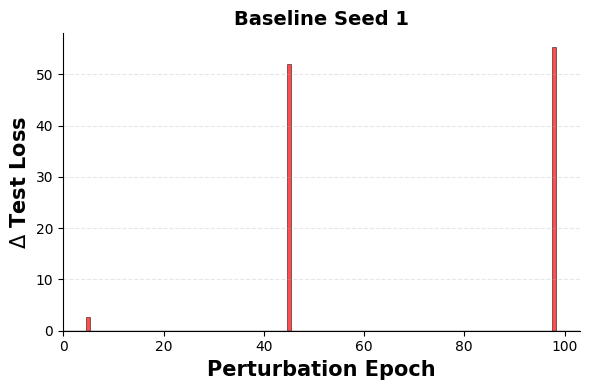


Test loss deviation at perturbation epoch statistics:
  Overall minimum: 2.70
  Overall maximum: 55.22
  Mean: 36.66
  Standard deviation: 24.05
  Range: 52.52

Deviation breakdown:
  Positive deviations (higher loss): 3
  Negative deviations (lower loss): 0
  Zero deviations (same loss): 0

Deviation examples:
  Run 5: +2.70 deviation
  Run 45: +52.07 deviation
  Run 98: +55.22 deviation


In [17]:
# Plot test loss deviation at perturbation epoch compared to baseline
shuff_label_deviations = []
run_numbers_shuff_label_deviation = []

for run_name, df in all_shuffle_label_data.items():
    run_num = int(run_name.split('run')[1])
    
    perturb_epoch = int(run_num)
    
    # Get test loss at perturbation epoch for this run
    run_at_perturb = df[df['epoch'] == perturb_epoch]
    
    # Get baseline test loss at the same epoch
    baseline_at_perturb = baseline_seed1_df[baseline_seed1_df['epoch'] == perturb_epoch]
    
    if len(run_at_perturb) > 0 and len(baseline_at_perturb) > 0:
        run_loss = run_at_perturb.iloc[0]['test_loss']
        baseline_loss = baseline_at_perturb.iloc[0]['test_loss']
        
        # Calculate deviation (run - baseline)
        deviation = run_loss - baseline_loss
        shuff_label_deviations.append(deviation)
        run_numbers_shuff_label_deviation.append(run_num)

# Sort by run number for proper ordering
sorted_data_shuff_label_deviation = sorted(zip(run_numbers_shuff_label_deviation, shuff_label_deviations))
run_numbers_shuff_label_deviation_sorted, shuff_label_deviations_sorted = zip(*sorted_data_shuff_label_deviation)

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['red' if dev > 0 else 'green' for dev in shuff_label_deviations_sorted]
ax.bar(run_numbers_shuff_label_deviation_sorted, shuff_label_deviations_sorted, alpha=0.7, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Perturbation Epoch', fontsize=15, fontweight='bold')
ax.set_ylabel('$\Delta$ Test Loss', fontsize=15, fontweight='bold')
ax.set_title('Baseline Seed 1', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)

# Add some statistics
min_deviation_overall = min(shuff_label_deviations_sorted)
max_deviation_overall = max(shuff_label_deviations_sorted)
mean_deviation = np.mean(shuff_label_deviations_sorted)

# Add mean line
# ax.axhline(y=mean_deviation, color='blue', linestyle='--', alpha=0.7, label=f'Mean: {mean_deviation:.2f}')
# ax.legend()

# Add text box with statistics
# stats_text_deviation = f'Min: {min_deviation_overall:.2f} (Epoch {run_numbers_deviation_sorted[np.argmin(perturbation_deviations_sorted)]})\nMax: {max_deviation_overall:.2f} (Epoch {run_numbers_deviation_sorted[np.argmax(perturbation_deviations_sorted)]})\nMean: {mean_deviation:.2f}\nStd: {np.std(perturbation_deviations_sorted):.2f}'
# ax.text(0.02, 0.98, stats_text_deviation, transform=ax.transAxes, 
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
#          fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTest loss deviation at perturbation epoch statistics:")
print(f"  Overall minimum: {min_deviation_overall:.2f}")
print(f"  Overall maximum: {max_deviation_overall:.2f}")
print(f"  Mean: {mean_deviation:.2f}")
print(f"  Standard deviation: {np.std(shuff_label_deviations_sorted):.2f}")
print(f"  Range: {max_deviation_overall - min_deviation_overall:.2f}")

# Count positive vs negative deviations
positive_deviations = sum(1 for dev in shuff_label_deviations_sorted if dev > 0)
negative_deviations = sum(1 for dev in shuff_label_deviations_sorted if dev < 0)
zero_deviations = sum(1 for dev in shuff_label_deviations_sorted if dev == 0)

print(f"\nDeviation breakdown:")
print(f"  Positive deviations (higher loss): {positive_deviations}")
print(f"  Negative deviations (lower loss): {negative_deviations}")
print(f"  Zero deviations (same loss): {zero_deviations}")

# Print some examples for verification
print(f"\nDeviation examples:")
for i in range(min(5, len(run_numbers_shuff_label_deviation_sorted))):
    run_num = run_numbers_shuff_label_deviation_sorted[i]
    deviation = shuff_label_deviations_sorted[i]
    print(f"  Run {run_num}: {deviation:+.2f} deviation")

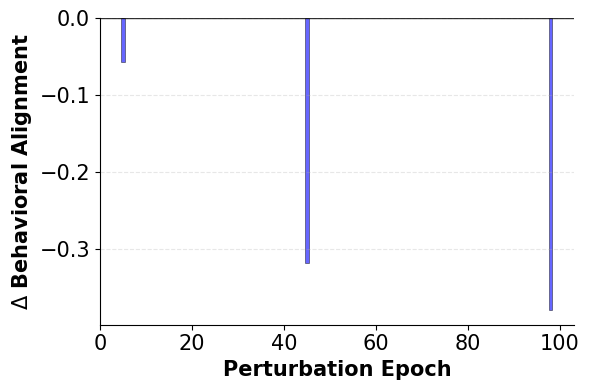


Behavioral alignment deviation at perturbation epoch statistics:
  Overall minimum: -0.3801
  Overall maximum: -0.0579
  Mean: -0.2523
  Standard deviation: 0.1397
  Range: 0.3222

Deviation breakdown:
  Positive deviations (higher alignment): 0
  Negative deviations (lower alignment): 3
  Zero deviations (same alignment): 0

Deviation examples:
  Run 5: -0.0579 deviation
  Run 45: -0.3189 deviation
  Run 98: -0.3801 deviation


In [18]:
# Plot behavioral alignment deviation at perturbation epoch compared to baseline
shuffle_label_perturbation_deviations_ba = []
shuffle_label_run_numbers_deviation_ba = []

for run_name, df in all_shuffle_label_data.items():
    run_num = int(run_name.split('run')[1])
    
    perturb_epoch = int(run_num)
    
    # Get behavioral alignment at perturbation epoch for this run
    run_at_perturb = df[df['epoch'] == perturb_epoch]
    
    # Get baseline behavioral alignment at the same epoch
    baseline_at_perturb = baseline_seed1_df[baseline_seed1_df['epoch'] == perturb_epoch]
    
    if len(run_at_perturb) > 0 and len(baseline_at_perturb) > 0:
        run_ba = run_at_perturb.iloc[0]['behavioral_rsa_rho']
        baseline_ba = baseline_at_perturb.iloc[0]['behavioral_rsa_rho']
        
        # Calculate deviation (run - baseline)
        deviation = run_ba - baseline_ba
        shuffle_label_perturbation_deviations_ba.append(deviation)
        shuffle_label_run_numbers_deviation_ba.append(run_num)

# Sort by run number for proper ordering
shuffle_label_sorted_data_deviation_ba = sorted(zip(shuffle_label_run_numbers_deviation_ba, shuffle_label_perturbation_deviations_ba))
shuffle_label_run_numbers_deviation_ba_sorted, shuffle_label_perturbation_deviations_ba_sorted = zip(*shuffle_label_sorted_data_deviation_ba)

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['green' if dev > 0 else 'blue' for dev in shuffle_label_perturbation_deviations_ba_sorted]
ax.bar(shuffle_label_run_numbers_deviation_ba_sorted, shuffle_label_perturbation_deviations_ba_sorted, alpha=0.6, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Perturbation Epoch', fontweight='bold', fontsize=15)
ax.set_ylabel(r'$\Delta$ Behavioral Alignment', fontweight='bold', fontsize=15)
#ax.set_title('Behavioral Alignment Deviation at Perturbation Epoch\n(Green = Higher Alignment, Red = Lower Alignment)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Increase tick label sizes for both x and y axes
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)

# Add some statistics
min_deviation_ba_overall = min(shuffle_label_perturbation_deviations_ba_sorted)
max_deviation_ba_overall = max(shuffle_label_perturbation_deviations_ba_sorted)
mean_deviation_ba = np.mean(shuffle_label_perturbation_deviations_ba_sorted)

# # Add text box with statistics
# stats_text_deviation_ba = f'Min: {min_deviation_ba_overall:.4f}\nMax: {max_deviation_ba_overall:.4f}\nMean: {mean_deviation_ba:.4f}\nStd: {np.std(perturbation_deviations_ba_sorted):.4f}'
# ax.text(0.02, 0.98, stats_text_deviation_ba, transform=ax.transAxes, 
#          verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
#          fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nBehavioral alignment deviation at perturbation epoch statistics:")
print(f"  Overall minimum: {min_deviation_ba_overall:.4f}")
print(f"  Overall maximum: {max_deviation_ba_overall:.4f}")
print(f"  Mean: {mean_deviation_ba:.4f}")
print(f"  Standard deviation: {np.std(shuffle_label_perturbation_deviations_ba_sorted):.4f}")
print(f"  Range: {max_deviation_ba_overall - min_deviation_ba_overall:.4f}")

# Count positive vs negative deviations
positive_deviations_ba = sum(1 for dev in shuffle_label_perturbation_deviations_ba_sorted if dev > 0)
negative_deviations_ba = sum(1 for dev in shuffle_label_perturbation_deviations_ba_sorted if dev < 0)
zero_deviations_ba = sum(1 for dev in shuffle_label_perturbation_deviations_ba_sorted if dev == 0)

print(f"\nDeviation breakdown:")
print(f"  Positive deviations (higher alignment): {positive_deviations_ba}")
print(f"  Negative deviations (lower alignment): {negative_deviations_ba}")
print(f"  Zero deviations (same alignment): {zero_deviations_ba}")

# Print some examples for verification
print(f"\nDeviation examples:")
for i in range(min(5, len(shuffle_label_run_numbers_deviation_ba_sorted))):
    run_num = shuffle_label_run_numbers_deviation_ba_sorted[i]
    deviation = shuffle_label_perturbation_deviations_ba_sorted[i]
    print(f"  Run {run_num}: {deviation:+.4f} deviation")

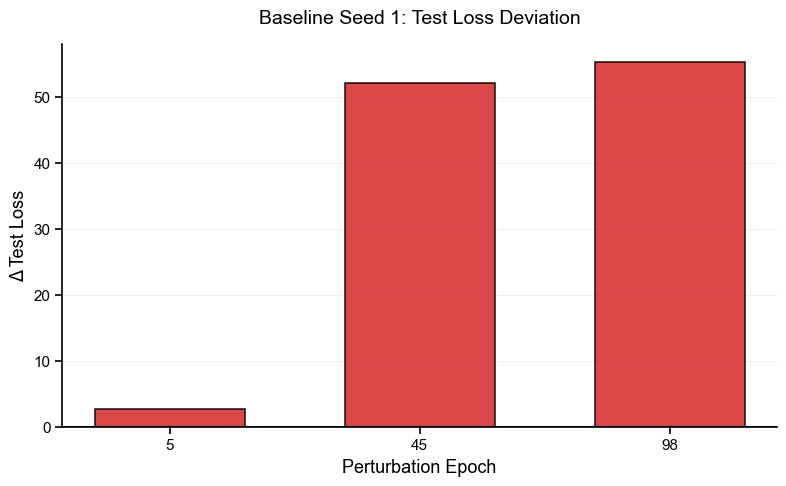


Test loss deviation at perturbation epoch statistics:
  Overall minimum: 2.70
  Overall maximum: 55.22
  Mean: 36.66
  Standard deviation: 24.05
  Range: 52.52

Deviation breakdown:
  Positive deviations (higher loss): 3
  Negative deviations (lower loss): 0
  Zero deviations (same loss): 0

Deviation examples:
  Run 5: +2.70 deviation
  Run 45: +52.07 deviation
  Run 98: +55.22 deviation


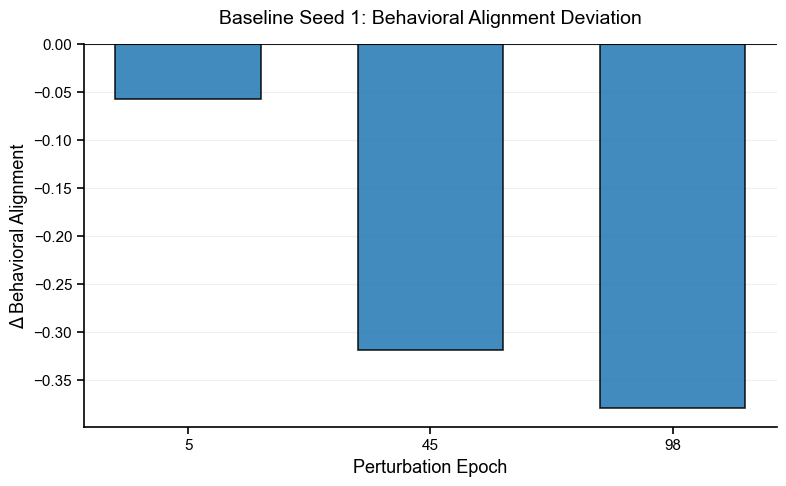


Behavioral alignment deviation at perturbation epoch statistics:
  Overall minimum: -0.3801
  Overall maximum: -0.0579
  Mean: -0.2523
  Standard deviation: 0.1397
  Range: 0.3222

Deviation breakdown:
  Positive deviations (higher alignment): 0
  Negative deviations (lower alignment): 3
  Zero deviations (same alignment): 0

Deviation examples:
  Run 5: -0.0579 deviation
  Run 45: -0.3189 deviation
  Run 98: -0.3801 deviation


FileNotFoundError: [Errno 2] No such file or directory: '/home/claude/combined_deviations_categorical.png'

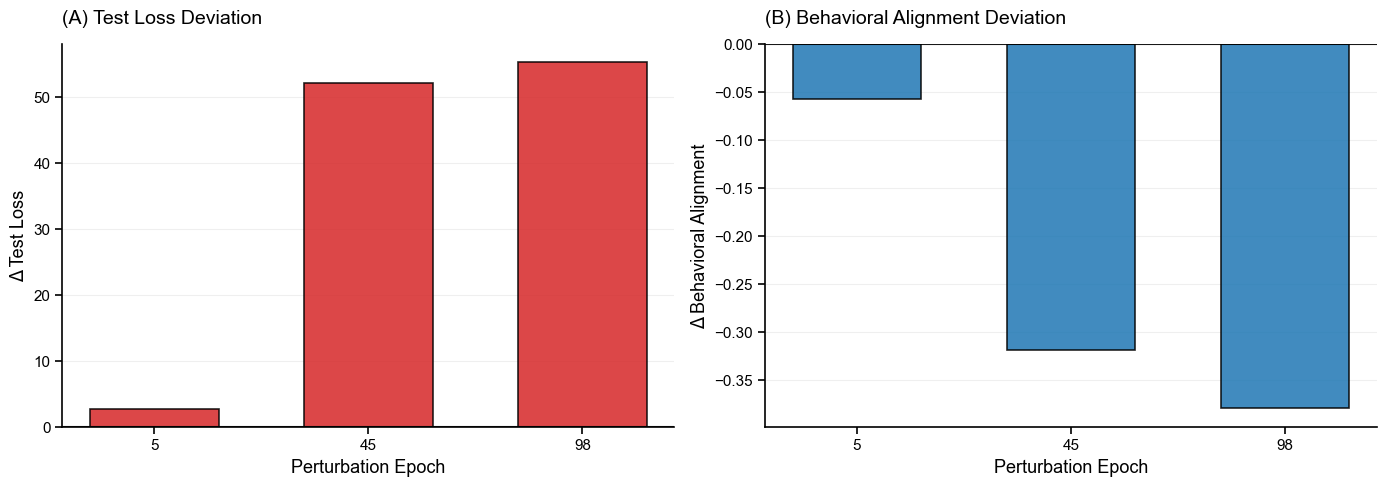

In [ ]:
## =============================================================================
# IMPROVED PLOTTING CODE WITH CATEGORICAL X-AXIS (CENTERED, EQUALLY-SPACED BARS)
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Set publication-quality defaults
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5

# =============================================================================
# PLOT 1: Test Loss Deviation - CATEGORICAL X-AXIS WITH WIDE BARS
# =============================================================================

# Sort by run number for proper ordering (your existing code)
sorted_data_shuff_label_deviation = sorted(zip(run_numbers_shuff_label_deviation, shuff_label_deviations))
run_numbers_shuff_label_deviation_sorted, shuff_label_deviations_sorted = zip(*sorted_data_shuff_label_deviation)

# Create the bar plot with improved aesthetics
fig, ax = plt.subplots(figsize=(8, 5))

# Better color scheme - more saturated and publication-ready
colors_tl = ['#d62728' if dev > 0 else '#2ca02c' for dev in shuff_label_deviations_sorted]

# Use categorical x-axis (positions 0, 1, 2, ...) instead of actual epoch numbers
x_positions = np.arange(len(run_numbers_shuff_label_deviation_sorted))

bars = ax.bar(x_positions, 
              shuff_label_deviations_sorted, 
              alpha=0.85,
              color=colors_tl, 
              edgecolor='black', 
              linewidth=1.2,
              width=0.6)  # Wide bars! (0.6 is good for categorical spacing)

# Set x-tick positions and labels to show actual epoch numbers
ax.set_xticks(x_positions)
ax.set_xticklabels(run_numbers_shuff_label_deviation_sorted)

# Labels with cleaner formatting
ax.set_xlabel('Perturbation Epoch', fontsize=13)
ax.set_ylabel('Δ Test Loss', fontsize=13)
ax.set_title('Baseline Seed 1: Test Loss Deviation', fontsize=14, pad=15)

# Improved grid - lighter and behind bars
ax.grid(True, alpha=0.2, linestyle='-', axis='y', linewidth=0.8)
ax.set_axisbelow(True)  # Put grid behind bars

# Clean up spines with consistent width
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# More prominent zero line
ax.axhline(y=0, color='black', linestyle='-', alpha=0.9, linewidth=1.5, zorder=3)

# Better tick formatting
ax.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

# Statistics (your existing code)
min_deviation_overall = min(shuff_label_deviations_sorted)
max_deviation_overall = max(shuff_label_deviations_sorted)
mean_deviation = np.mean(shuff_label_deviations_sorted)

print(f"\nTest loss deviation at perturbation epoch statistics:")
print(f"  Overall minimum: {min_deviation_overall:.2f}")
print(f"  Overall maximum: {max_deviation_overall:.2f}")
print(f"  Mean: {mean_deviation:.2f}")
print(f"  Standard deviation: {np.std(shuff_label_deviations_sorted):.2f}")
print(f"  Range: {max_deviation_overall - min_deviation_overall:.2f}")

# Count positive vs negative deviations (your existing code)
positive_deviations = sum(1 for dev in shuff_label_deviations_sorted if dev > 0)
negative_deviations = sum(1 for dev in shuff_label_deviations_sorted if dev < 0)
zero_deviations = sum(1 for dev in shuff_label_deviations_sorted if dev == 0)

print(f"\nDeviation breakdown:")
print(f"  Positive deviations (higher loss): {positive_deviations}")
print(f"  Negative deviations (lower loss): {negative_deviations}")
print(f"  Zero deviations (same loss): {zero_deviations}")

# Print some examples for verification (your existing code)
print(f"\nDeviation examples:")
for i in range(min(5, len(run_numbers_shuff_label_deviation_sorted))):
    run_num = run_numbers_shuff_label_deviation_sorted[i]
    deviation = shuff_label_deviations_sorted[i]
    print(f"  Run {run_num}: {deviation:+.2f} deviation")

# =============================================================================
# PLOT 2: Behavioral Alignment Deviation - CATEGORICAL X-AXIS WITH WIDE BARS
# =============================================================================

# Sort by run number for proper ordering (your existing code)
shuffle_label_sorted_data_deviation_ba = sorted(zip(shuffle_label_run_numbers_deviation_ba, 
                                                     shuffle_label_perturbation_deviations_ba))
shuffle_label_run_numbers_deviation_ba_sorted, shuffle_label_perturbation_deviations_ba_sorted = \
    zip(*shuffle_label_sorted_data_deviation_ba)

# Create the bar plot with improved aesthetics
fig, ax = plt.subplots(figsize=(8, 5))

# Better color scheme - green for positive (better alignment), blue for negative
colors_ba = ['#2ca02c' if dev > 0 else '#1f77b4' for dev in shuffle_label_perturbation_deviations_ba_sorted]

# Use categorical x-axis (positions 0, 1, 2, ...) instead of actual epoch numbers
x_positions_ba = np.arange(len(shuffle_label_run_numbers_deviation_ba_sorted))

bars = ax.bar(x_positions_ba, 
              shuffle_label_perturbation_deviations_ba_sorted, 
              alpha=0.85,
              color=colors_ba, 
              edgecolor='black', 
              linewidth=1.2,
              width=0.6)  # Wide bars! (0.6 is good for categorical spacing)

# Set x-tick positions and labels to show actual epoch numbers
ax.set_xticks(x_positions_ba)
ax.set_xticklabels(shuffle_label_run_numbers_deviation_ba_sorted)

# Labels with cleaner formatting
ax.set_xlabel('Perturbation Epoch', fontsize=13)
ax.set_ylabel('Δ Behavioral Alignment', fontsize=13)
ax.set_title('Baseline Seed 1: Behavioral Alignment Deviation', fontsize=14, pad=15)

# Improved grid
ax.grid(True, alpha=0.2, linestyle='-', axis='y', linewidth=0.8)
ax.set_axisbelow(True)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# More prominent zero line
ax.axhline(y=0, color='black', linestyle='-', alpha=0.9, linewidth=1.5, zorder=3)

# Better tick formatting
ax.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

# Statistics (your existing code)
min_deviation_ba_overall = min(shuffle_label_perturbation_deviations_ba_sorted)
max_deviation_ba_overall = max(shuffle_label_perturbation_deviations_ba_sorted)
mean_deviation_ba = np.mean(shuffle_label_perturbation_deviations_ba_sorted)

print(f"\nBehavioral alignment deviation at perturbation epoch statistics:")
print(f"  Overall minimum: {min_deviation_ba_overall:.4f}")
print(f"  Overall maximum: {max_deviation_ba_overall:.4f}")
print(f"  Mean: {mean_deviation_ba:.4f}")
print(f"  Standard deviation: {np.std(shuffle_label_perturbation_deviations_ba_sorted):.4f}")
print(f"  Range: {max_deviation_ba_overall - min_deviation_ba_overall:.4f}")

# Count positive vs negative deviations (your existing code)
positive_deviations_ba = sum(1 for dev in shuffle_label_perturbation_deviations_ba_sorted if dev > 0)
negative_deviations_ba = sum(1 for dev in shuffle_label_perturbation_deviations_ba_sorted if dev < 0)
zero_deviations_ba = sum(1 for dev in shuffle_label_perturbation_deviations_ba_sorted if dev == 0)

print(f"\nDeviation breakdown:")
print(f"  Positive deviations (higher alignment): {positive_deviations_ba}")
print(f"  Negative deviations (lower alignment): {negative_deviations_ba}")
print(f"  Zero deviations (same alignment): {zero_deviations_ba}")

# Print some examples for verification (your existing code)
print(f"\nDeviation examples:")
for i in range(min(5, len(shuffle_label_run_numbers_deviation_ba_sorted))):
    run_num = shuffle_label_run_numbers_deviation_ba_sorted[i]
    deviation = shuffle_label_perturbation_deviations_ba_sorted[i]
    print(f"  Run {run_num}: {deviation:+.4f} deviation")

# =============================================================================
# OPTIONAL: Create combined figure with both plots side-by-side - CATEGORICAL
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Test Loss Deviation
x_positions = np.arange(len(run_numbers_shuff_label_deviation_sorted))
colors_tl = ['#d62728' if dev > 0 else '#2ca02c' for dev in shuff_label_deviations_sorted]
ax1.bar(x_positions, 
        shuff_label_deviations_sorted, 
        alpha=0.85,
        color=colors_tl, 
        edgecolor='black', 
        linewidth=1.2,
        width=0.6)  # Wide bars!
ax1.set_xticks(x_positions)
ax1.set_xticklabels(run_numbers_shuff_label_deviation_sorted)
ax1.set_xlabel('Perturbation Epoch', fontsize=13)
ax1.set_ylabel('Δ Test Loss', fontsize=13)
ax1.set_title('(A) Test Loss Deviation', fontsize=14, pad=15, loc='left')
ax1.grid(True, alpha=0.2, linestyle='-', axis='y', linewidth=0.8)
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.2)
ax1.spines['bottom'].set_linewidth(1.2)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.9, linewidth=1.5, zorder=3)
ax1.tick_params(axis='both', which='major', labelsize=11)

# Right plot: Behavioral Alignment Deviation
x_positions_ba = np.arange(len(shuffle_label_run_numbers_deviation_ba_sorted))
colors_ba = ['#2ca02c' if dev > 0 else '#1f77b4' for dev in shuffle_label_perturbation_deviations_ba_sorted]
ax2.bar(x_positions_ba, 
        shuffle_label_perturbation_deviations_ba_sorted, 
        alpha=0.85,
        color=colors_ba, 
        edgecolor='black', 
        linewidth=1.2,
        width=0.6)  # Wide bars!
ax2.set_xticks(x_positions_ba)
ax2.set_xticklabels(shuffle_label_run_numbers_deviation_ba_sorted)
ax2.set_xlabel('Perturbation Epoch', fontsize=13)
ax2.set_ylabel('Δ Behavioral Alignment', fontsize=13)
ax2.set_title('(B) Behavioral Alignment Deviation', fontsize=14, pad=15, loc='left')
ax2.grid(True, alpha=0.2, linestyle='-', axis='y', linewidth=0.8)
ax2.set_axisbelow(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1.2)
ax2.spines['bottom'].set_linewidth(1.2)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.9, linewidth=1.5, zorder=3)
ax2.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

print("\nCombined figure with categorical x-axis (centered, equally-spaced bars) saved!")

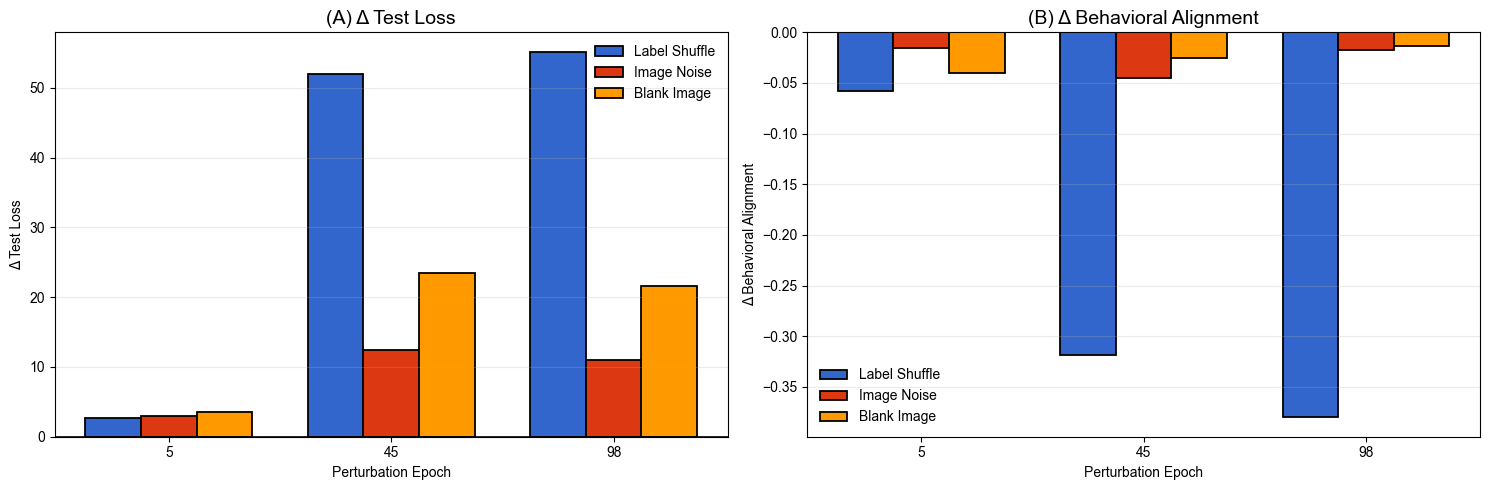

In [11]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np


# =============================================================================
# LOAD BASELINE (TRIM AT MIN TEST LOSS)
# =============================================================================

baseline_seed1_csv = Path(
    '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/'
    'baseline_runs/clip_hba_behavior_seed1/training_results/training_res_seed1.csv'
)

baseline_df = pd.read_csv(baseline_seed1_csv)
baseline_min_idx = baseline_df['test_loss'].idxmin()
baseline_df = baseline_df.loc[:baseline_min_idx].copy()


# =============================================================================
# HELPERS
# =============================================================================

def load_run_epoch_value(root_dir, run_number):
    """Load test_loss at epoch == run_number."""
    run_dir = Path(root_dir) / f"training_run{run_number}"
    csv_file = run_dir / f"training_res_run{run_number}.csv"

    if not csv_file.exists():
        print(f"[WARNING] Missing run {run_number}")
        return None

    df = pd.read_csv(csv_file)

    if "epoch" not in df.columns:
        return None

    row = df[df['epoch'] == run_number]
    if len(row) == 0:
        return None

    return float(row.iloc[0]["test_loss"])


def baseline_epoch_loss(epoch):
    """Return baseline loss at same epoch."""
    if epoch not in baseline_df["epoch"].values:
        print(f"[WARNING] Baseline missing epoch {epoch}")
        return None
    return float(baseline_df[baseline_df["epoch"] == epoch]["test_loss"].iloc[0])


def load_all_run_data(root):
    """Load all training_run*/training_res_run*.csv into dict."""
    root = Path(root)
    all_data = {}
    
    for run_dir in sorted(root.glob("training_run*")):
        if run_dir.is_dir():
            run_num = run_dir.name.split("run")[1]
            csv = run_dir / f"training_res_run{run_num}.csv"
            if csv.exists():
                all_data[run_dir.name] = pd.read_csv(csv)
    return all_data


def compute_ba_from_dict(all_data, baseline_df, target_epochs):
    """Compute Δ behavioral alignment."""
    deviations = []
    for epoch in target_epochs:
        run_name = f"training_run{epoch}"

        if run_name not in all_data:
            deviations.append(np.nan)
            continue

        df = all_data[run_name]
        row = df[df['epoch'] == epoch]
        base_row = baseline_df[baseline_df['epoch'] == epoch]

        if len(row) == 0 or len(base_row) == 0:
            deviations.append(np.nan)
            continue

        run_ba = float(row.iloc[0]["behavioral_rsa_rho"])
        base_ba = float(base_row.iloc[0]["behavioral_rsa_rho"])

        deviations.append(run_ba - base_ba)

    return deviations


# =============================================================================
# ROOTS
# =============================================================================

label_shuffle_root = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/label_shuffle_single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42'
image_noise_root  = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/marren_image_noise_single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42'
blank_image_root  = '/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/marren_uniform_target_single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42'


# =============================================================================
# COMPUTE Δ TEST LOSS FOR EPOCHS 5, 45, 98
# =============================================================================

target_epochs = [5, 45, 98]

def compute_deltas(root):
    deviations = []
    for ep in target_epochs:
        run_loss = load_run_epoch_value(root, ep)
        base_loss = baseline_epoch_loss(ep)
        if run_loss is None or base_loss is None:
            deviations.append(np.nan)
        else:
            deviations.append(run_loss - base_loss)
    return deviations

ls_dev = compute_deltas(label_shuffle_root)
in_dev = compute_deltas(image_noise_root)
bi_dev = compute_deltas(blank_image_root)


# =============================================================================
# LOAD PER-RUN CSVs AND COMPUTE Δ BEHAVIORAL ALIGNMENT
# =============================================================================

all_shuffle_label_data = load_all_run_data(label_shuffle_root)
all_image_noise_data  = load_all_run_data(image_noise_root)
all_blank_image_data  = load_all_run_data(blank_image_root)

ls_ba = compute_ba_from_dict(all_shuffle_label_data, baseline_df, target_epochs)
in_ba = compute_ba_from_dict(all_image_noise_data, baseline_df, target_epochs)
bi_ba = compute_ba_from_dict(all_blank_image_data, baseline_df, target_epochs)


# =============================================================================
# PREPARE MATRICES FOR GROUPED PLOTS
# =============================================================================

test_loss_matrix = np.array([ls_dev, in_dev, bi_dev])
behavior_matrix  = np.array([ls_ba, in_ba, bi_ba])

perturb_names = ["Label Shuffle", "Image Noise", "Blank Image"]
epochs = target_epochs

x = np.arange(len(epochs))
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]


# =============================================================================
# PLOT FIGURE
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

colors = ["#3366CC", "#DC3912", "#FF9900"]


# ---- Panel A: Δ Test Loss ----
for i in range(3):
    ax1.bar(
        x + offsets[i],
        test_loss_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax1.axhline(0, color='black', linewidth=1.2)
ax1.set_xticks(x)
ax1.set_xticklabels(epochs)
ax1.set_title("(A) Δ Test Loss", fontsize=14)
ax1.set_xlabel("Perturbation Epoch")
ax1.set_ylabel("Δ Test Loss")
ax1.grid(axis="y", alpha=0.25)
ax1.legend(frameon=False)


# ---- Panel B: Δ Behavioral Alignment ----
for i in range(3):
    ax2.bar(
        x + offsets[i],
        behavior_matrix[i],
        width=bar_width,
        label=perturb_names[i],
        color=colors[i],
        edgecolor='black',
        linewidth=1.3
    )

ax2.axhline(0, color='black', linewidth=1.2)
ax2.set_xticks(x)
ax2.set_xticklabels(epochs)
ax2.set_title("(B) Δ Behavioral Alignment", fontsize=14)
ax2.set_xlabel("Perturbation Epoch")
ax2.set_ylabel("Δ Behavioral Alignment")
ax2.grid(axis="y", alpha=0.25)
ax2.legend(frameon=False)


plt.tight_layout()
plt.show()
